![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# Deep Learning - Using Neural Networks to classify CIFAR10 Images

Can you classify an image from the CIFAR10 image library using a Neural Network?

## Table of Contents

* [1. Introduction](#introduction)
* [2. Importing libraries](#libraries)
* [3. Importing and preparing the data](#data)
* [4. Neural Network models](#nn_models)
    * [4.1. Simplest model](#simplest_model)
        * [4.1.1. Model definition](#model_definition)
        * [4.1.2. Optimizer, error function](#optimizer_error)
        * [4.1.3. Model training](#training)
        * [4.1.4. Model evaluation](#evaluation)
    * [4.2. Adding more Dense layers](#more_dense_layers)
* [5. Models comparison](#comparison)


## 1. Introduction <a class="anchor" id="introduction"></a>

The main goal of this project is to test several Neural Networks configurations in order to do the proper classification of the CIFAR10 image dataset.

## 2. Importing libraries <a class="anchor" id="libraries"></a>

In [48]:
# data manipulation libraries
import numpy as np
import pandas as pd

# neural network libraries
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# plotting libraries
from matplotlib import pyplot as plt

# time libraries
import time
import datetime

In [2]:
# constants
EPOCHS = 100
INPUT_SHAPE = (32, 32, 3)
ACC_TARGET = 0.8 # accuracy target we want to at least achieve with our models

## 3. Importing and preparing the data <a class="anchor" id="data"></a>

CIFAR10 is an existing dataset already available in the Keras library. These are already ready in train and test datasets (we'll need to create the validation dataset later).

**Important detail:**
> The neural network requires the inputs to be real numbers, and we will do it by forcing the division of the values ​​within the 28x28 matrices (which have values​​ from 0 to 255) by 255.0 (a real)

In [3]:
cifar10 = ks.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Let's explore the data to see what we have

In [4]:
print('Train: X = %s, y = %s' % (x_train.shape, y_train.shape))
print('Test: X = %s, y = %s' % (x_test.shape, y_test.shape))

Train: X = (50000, 32, 32, 3), y = (50000, 1)
Test: X = (10000, 32, 32, 3), y = (10000, 1)


For training, we have 50000 images of 32x32 pixels, split in the color channels (R, G, B). For testing, we only have 1000 images, but, obviously, of the same format as the training dataset.

Let's see what are the different categories we have in the dataset.

In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

As expected, there are 10 categories that are already encoded into numbers. However, we will generate a label list for future plotting purposes.

In [6]:
cifar10_labels = [
'airplane', # id 0
'automobile', # id 1
'bird', # id 2
'cat', # id 3
'deer', # id 4
'dog', # id 5
'frog', # id 6
'horse', # id 7
'ship', # id 8
'truck', # id 9
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Let's show a sample of the images from the CIFAR10 dataset, to see if it looks anything like what we expect.

First, we see what types of data we have, then we map those arrays in a grayscale using the **. Get_cmap ()** method of Plotly with the first nine numbers of the dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


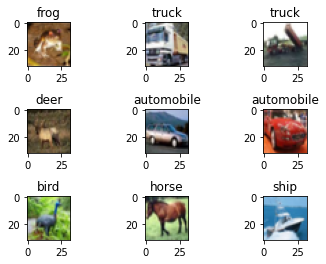

In [7]:
# Let's show a sample of the images of CIFAR10

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap = plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Let's start preparing the datasets for the models we will train. 

We are we going to validate while we train (very practical). We'll be removing the last 10000 entries in `x_train` for our validation dataset. 

In [8]:
# generating the validation dataset
x_val = x_train[-10000:]
y_val = y_train[-10000:]

# modifying the training dataset to exclude the validation dataset
x_train = x_train[:-10000]
y_train = y_train[:-10000]

When we add convolution layers, we need to "pre-treat the data", because **the convolution expects an array of 4 fields** (more like coloured "images"), in the case of MNIST. However, CIFAR10 already has the right shape, so we don't have to do anything, but as we always say: you should better check its size.

Therefore, when exiting the Convolution, you always have to do a Flatten, because FullDense layers expect arrays, not matrices !!

Let's validate the format.

In [9]:
# We validate the result
print('Train: X = %s, y = %s' % (x_train.shape, y_train.shape))
print('Test: X = %s, y = %s' % (x_test.shape, y_test.shape))
print('Validation: X = %s, y = %s' % (x_val.shape, y_val.shape))

Train: X = (40000, 32, 32, 3), y = (40000, 1)
Test: X = (10000, 32, 32, 3), y = (10000, 1)
Validation: X = (10000, 32, 32, 3), y = (10000, 1)


## 4. Neural Network Models <a class="anchor" id="nn_models"></a>

In the following sections, we are going to define and train up to 10 different Neural Network models to see which arquitecture is providing the best accuracy.

Nonetheless, before starting with the models let's set a couple of previous tunings that will help us later with the training

In [10]:
# defining callbacks for EarlyStopping
callback_loss = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
callback_accuracy = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)

# list to keep the model results for final comparison
model_evaluations = []

### 4.1. Simplest model <a class="anchor" id="simplest_model"></a>

Let's start with the simplest model possible with a single Dense Layer

#### 4.1.1. Model definition <a class="anchor" id="model_definition"></a>


In [11]:
model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = INPUT_SHAPE))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


#### 4.1.2. Optimizer, error function <a class="anchor" id="optimizer_error"></a>


In [12]:
# compiling model
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### 4.1.3. Training <a class="anchor" id="training"></a>

In order to train the model we have setup a global constant of 100 EPOCHS, which we expect to never reach, as we have implemented a callback to stop training once the accuracy or the cross entropy loss doesn't improve that much. Additionally, we are going to keep the best weights to get the most optimal results for the model.

In [13]:
# calculating computational time
t = time.perf_counter()

# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 128, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )

# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\nTraining time:', elapsed_time)

Epoch 1/100
313/313 [==============================] - 3s 8ms/step - loss: 1.9568 - accuracy: 0.3000 - val_loss: 1.8233 - val_accuracy: 0.3627
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 1.7881 - accuracy: 0.3667 - val_loss: 1.7754 - val_accuracy: 0.3742
Epoch 3/100
313/313 [==============================] - 2s 5ms/step - loss: 1.7214 - accuracy: 0.3897 - val_loss: 1.7430 - val_accuracy: 0.3798
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 1.6743 - accuracy: 0.4064 - val_loss: 1.7495 - val_accuracy: 0.3693
Epoch 5/100
313/313 [==============================] - 2s 6ms/step - loss: 1.6470 - accuracy: 0.4153 - val_loss: 1.6588 - val_accuracy: 0.4156
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 1.6167 - accuracy: 0.4298 - val_loss: 1.6565 - val_accuracy: 0.4145
Epoch 7/100
313/313 [==============================] - 2s 6ms/step - loss: 1.5992 - accuracy: 0.4352 - val_loss: 1.6307 - val_accuracy: 0.4254

#### 4.1.4. Evaluation <a class="anchor" id="evaluation"></a>

Let's obtain a graph of how the entropy and the accuracy evolve in each epoch in the training data and in the validation

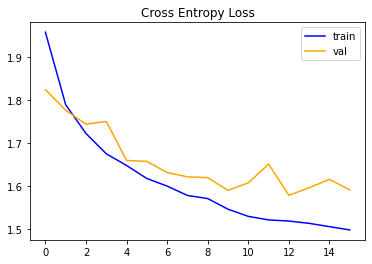

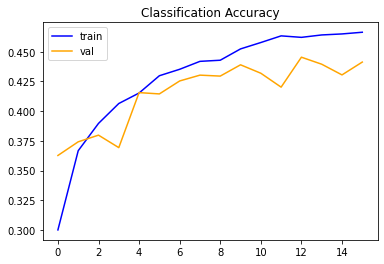

In [14]:
# cross entropy loss plot
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

# accuracy plot
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

The callbacks have stopped before EPOCH = 100 as we reached the top accuracy a lot before, and from that training session we got the best parameters parameters. However, we have seen that the validation accuracy looks really bad, so our hopes are not that high fo the test accuracy, but let's check it out.

In [15]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy for the model -> {round((acc * 100.0), 4)} %')

Test Accuracy for the model -> 45.95 %


As expected, the model is really bad. With this accuracy we can say that this is a really bad model that requires an improvement.

Let's see what kind of predictions we're getting on the test set (let's paint the images and their classifications).

In [16]:
predictions = model.predict(x_test)

In [17]:
# plotting helper functions
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')

def plot_cifar_results(predictions, x_test, y_test, num_rows = 5, num_cols = 4):
    i = 0
    for l in cifar10_labels:
        print(i, l)
        i += 1

    num_images = num_rows * num_cols
    start = np.random.randint(1000 - num_images)
    plt.figure(figsize = (2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i +1)
        plot_image(i + start, predictions[i + start], y_test, x_test)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i + start, predictions[i + start], y_test)
    plt.tight_layout()
    plt.show()

We draw the first images, with the predictions and their real values ​​(a total of 20 images, so as not to abuse your laptops)

We color the correct predictions in blue and the failures in red. Although I have printed the labels first so that we have a reference to the graphic.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


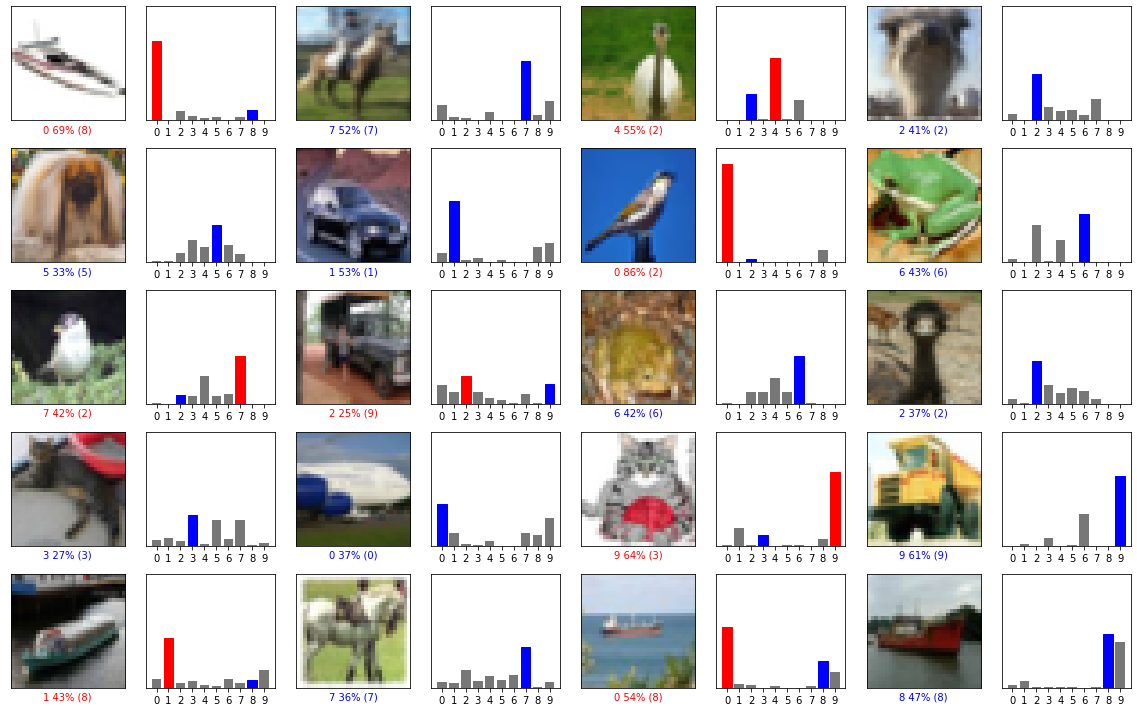

In [18]:
plot_cifar_results(predictions, x_test, y_test)

Let's see if we can build up the previous model to improve the accuracy, but before that, let's store the accuracy of this model so we can compare it at the end with all the other models.

In [19]:
# keeping accuracies for a final analysis
model_evaluations.append(
    {
        'model_name': "Single Dense Layer",
        'training_time': elapsed_time,
        'accuracy': acc
    }
)

### 4.2. Adding more Dense layers <a class="anchor" id="more_dense_layers"></a>

Before defining the model we will create some additional functions to avoid code repetition and possible errors. The idea is to prepare as much of a pipeline as possible so we can analyse results more easily.

In [20]:
def model_evaluation(model, x_test, y_test, history, plot_graphs = True, plot_images = True):
    if plot_graphs:
        # cross entropy loss plot
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='val')
        plt.legend()
        plt.show()

        # accuracy plot
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='val')
        plt.legend()
        plt.show()

    # accuracy evaluation
    _, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test Accuracy for the model -> {round((acc * 100.0), 4)} %')

    predictions = model.predict(x_test)

    if plot_images:
        plot_cifar_results(predictions, x_test, y_test)
    
    return acc

def storing_evaluation_results(model_list, model_name, accuracy, training_time):
    model_list.append(
        {
          'model_name': model_name,
          'training_time': training_time,
          'accuracy': accuracy
        }
    )

From the previous model, we have seen that with just one fully Dense layer is not enough for the model to work properly, in this case, we will be adding more Dense Layers to see if the result improves.

In [21]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = INPUT_SHAPE))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 128, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, False, False)

DEFINITION
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1573376   
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,746,506
Trainable params: 1

In [22]:
# STORING RESULTS

# keeping accuracies for a final analysis
storing_evaluation_results(model_evaluations, 'Several Dense Layers', acc, elapsed_time)

### 4.3. Do batch sizes matter? <a class="anchor" id="batch_sizes"></a>

Let's explore if the batch sizes of data can help us improve the training of our model or not. We will increase batch_size to 512, instead of 128.

In [23]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = INPUT_SHAPE))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, False, False)

DEFINITION
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               1573376   
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,746,506
Trainable params: 1

In [24]:
storing_evaluation_results(model_evaluations, 'Increasing Batch Size', acc, elapsed_time)

### 4.4. Exploring the effects of adding Dropout <a class="anchor" id="dropout"></a>


Dropout is referred to the effect of randomly removing nodes in a neural network and it is a technique to avoid overfitting. This makes sense to do in the Dense or fully connected layers. 

Let's see if that improves the results.

In [25]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = INPUT_SHAPE))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 1024, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, False, False)

DEFINITION
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)   

In [26]:
storing_evaluation_results(model_evaluations, 'Adding Dropout Layers', acc, elapsed_time)

### 4.5. Exploring convolutional neural networks <a class="anchor" id="simple_cnn"></a>

Up until now, we have tried to solve the classification problem by forcing the neural network to learn about values of pixels (features) in different color spaces, but what if we could provide it with "vision". If the network was able to see and understand the shapes of the image data it gets, we believe it would be more efficient.

Let's start with a simple Convolutional Network and expand from there.

In [27]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))


# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, False, False)

DEFINITION
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                           

With just one convolutional, the increase in accuracy has been impressive, but not enough.

In [28]:
storing_evaluation_results(model_evaluations, 'Simple Convolutional Neural Network', acc, elapsed_time)

### 4.6. Extending convolutional neural networks <a class="anchor" id="cnn"></a>

We have seen that by adding one layer of a convolutional neural network, the accuracy of the model improves a lot. Let's try adding more convolutional layers, following the examples of more complex architectures of neural networks that have several convolutional layers and then fully connected layers at the end.

In [29]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Conv2D(16, (3, 3), strides = 1, activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(256, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(64, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, False, False)

DEFINITION
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 

Adding convolutional layers has deeply increased the accuracy of our previous neural network

In [30]:
storing_evaluation_results(model_evaluations, 'Complex Convolutional Neural Network', acc, elapsed_time)

### 4.7. Tweaking the convolutional layer a little bit more <a class="anchor" id="cnn_tweaks"></a>

Another idea to increase the accuracy would be to make the convolutional layer bigger (VGG16 has 5 convolutional layers with higher amount of nodes than the previous model), and also make the classification layer (the fully connected one) a lot way bigger.

In [31]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Conv2D(64, (3, 3), strides = 1, activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(256, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(4096, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, False, False)

DEFINITION
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 

In [32]:
storing_evaluation_results(model_evaluations, 'VGG16-like CNN', acc, elapsed_time)

### 4.8. Using Data Augmentation <a class="anchor" id="data_augmentation"></a>

With a pretty complex convolutional network, we managed to increase the accuracy quite a lot. However, we are always aiming for a better model. The following approach will make use of Data Augmentation to improve the accuracy of the model by using very simple techniques of image processing to artificially expand the size of the training data by creating modified versions of the images of the original data.

#### 4.8.1. Creating our Image Train Generator <a class="anchor" id="train_generator"></a>

In [79]:
# train data
train_datagen = ImageDataGenerator(
      rotation_range = 40,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train,
    y_train, 
    batch_size = 80
)

In [80]:
# validation data
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(
    x_val, 
    y_val, 
    batch_size = 50
)


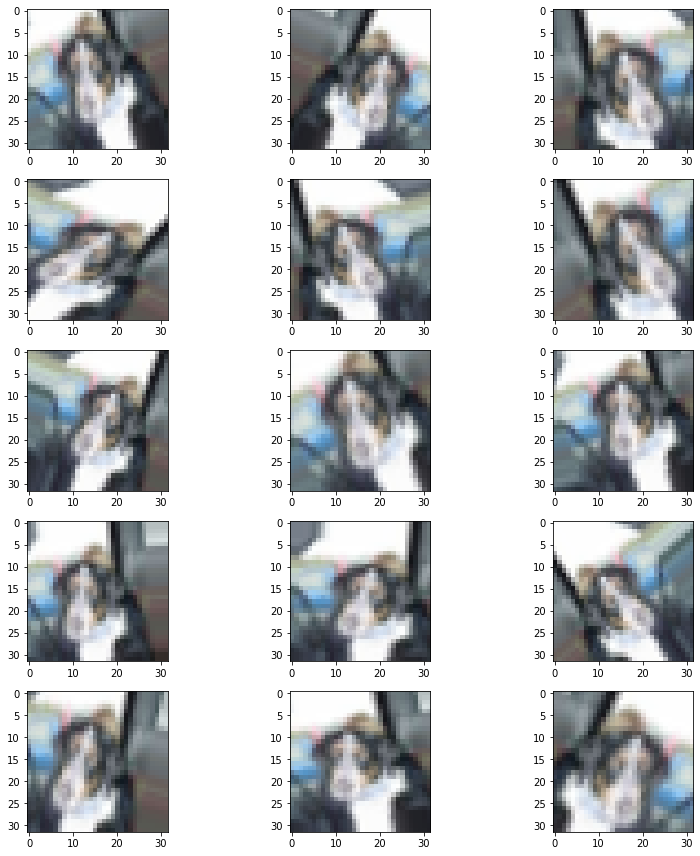

In [81]:
# checking the transformations of the already created generators

sample = np.random.choice(range(0,4999))

example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(12, 12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#### 4.8.2. Training the model with the image train generator <a class="anchor" id="train_generator_training_model"></a>

In [86]:
#TODO: Review

# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers

model.add(ks.layers.Conv2D(64, (3, 3), strides = 1, activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(256, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(512, (3, 3), strides = 1, activation = 'relu', padding = 'same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(4096, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer = "Adam",
              loss ='sparse_categorical_crossentropy',
              metrics = ['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    train_generator, 
                    validation_data = validation_generator,
                    epochs = EPOCHS, 
                    steps_per_epoch = 100,
                    validation_steps = 150,
                    use_multiprocessing = False, 
                    batch_size = 64,
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, False, False)

DEFINITION
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_136 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_134 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_137 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 8, 8, 128)        0         
 ng2D)                                                           
                                                                 
 conv2d_138 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 4, 4,

KeyboardInterrupt: ignored

In [37]:
storing_evaluation_results(model_evaluations, 'CNN using Data Augmentation', acc, elapsed_time)

## 5. Models comparison <a class="anchor" id="comparison"></a>

In [106]:
# generating a dataframe with all models and its results
df = pd.DataFrame(model_evaluations)

# converting training_time timedelta to seconds
df['training_time'] = df['training_time'].apply(lambda x: round(x.total_seconds(), 2))


In [107]:
df

,model_name,training_time,accuracy
0,Single Dense Layer,28.75,0.4595
1,Several Dense Layers,20.95,0.5010
2,Increasing Batch Size,6.62,0.4681
3,Adding Dropout Layers,13.55,0.4465
4,Simple Convolutional Neural Network,12.44,0.6255
5,Complex Convolutional Neural Network,16.69,0.6749
6,VGG16-like CNN,38.62,0.7061
7,CNN using Data Augmentation,22.56,0.3061


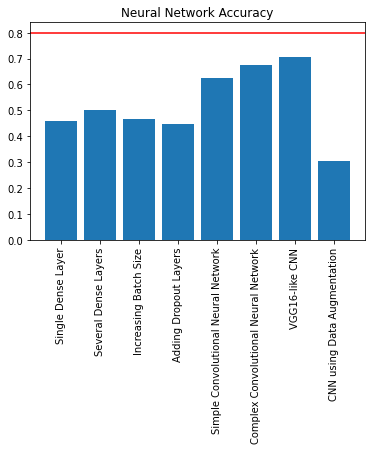

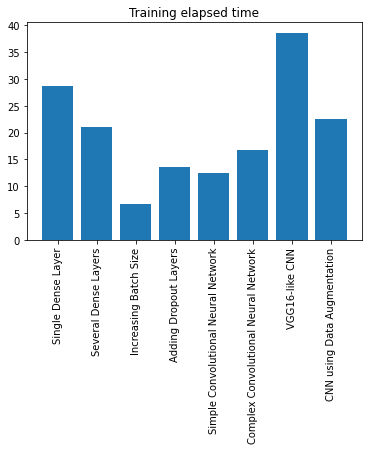

In [109]:
plt.title('Neural Network Accuracy')
plt.bar(x = df['model_name'], height = df['accuracy'])
plt.axhline(y=ACC_TARGET, color='r', linestyle='-')
plt.xticks(rotation = 90)
plt.show()

plt.title('Training elapsed time')
plt.bar(x = df['model_name'], height = df['training_time'])
plt.xticks(rotation = 90)
plt.show()

In [40]:
# plotting results

"""

# Test Accuracy
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

# accuracy plot
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()
"""

"\n\n# Test Accuracy\nplt.title('Cross Entropy Loss')\nplt.plot(history.history['loss'], color='blue', label='train')\nplt.plot(history.history['val_loss'], color='orange', label='val')\nplt.legend()\nplt.show()\n\n# accuracy plot\nplt.title('Classification Accuracy')\nplt.plot(history.history['accuracy'], color='blue', label='train')\nplt.plot(history.history['val_accuracy'], color='orange', label='val')\nplt.legend()\nplt.show()\n"

In [41]:
# TODO: Keep the model for later

#model = ks.Sequential()

#model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=INPUT_SHAPE))
#model.add(ks.layers.MaxPooling2D((2, 2)))

#model.add(ks.layers.Flatten()) 
#model.add(ks.layers.Dense(32, activation='relu'))
#model.add(ks.layers.Dense(10, activation='softmax'))

In [42]:
"""
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
"""

"\nweight_decay = 1e-4\nmodel = Sequential()\nmodel.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))\nmodel.add(Activation('elu'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))\nmodel.add(Activation('elu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2,2)))\nmodel.add(Dropout(0.2))\n \nmodel.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))\nmodel.add(Activation('elu'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))\nmodel.add(Activation('elu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2,2)))\nmodel.add(Dropout(0.3))\n \nmodel.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))\nmodel.add(Activation('elu'))\nmodel.add(BatchNorma

In [ ]:
# MODEL DEFINITION
print("DEFINITION")

model = ks.Sequential()

# Neural Network Layers

model.add(ks.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.25))

model.add(ks.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.4))

model.add(ks.layers.Flatten()) 
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()


# COMPILING MODEL
print("\nCompiling model...")
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TRAINING
print("\nTRAINING")
# calculating computational time
t = time.perf_counter()
# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 512, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )
# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\n\nTraining time:', elapsed_time)


# EVALUATION
print("\nEVALUATION")
acc = model_evaluation(model, x_test, y_test, history, False, False)